In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import gc # Free up memory

import scipy.stats
import scipy.special
import scipy.optimize

import copy

In [13]:
def get_predictions(df, t, start):
    # Previously returned as np array, changed to series for compatability with filtered datasets
    try:
        return df.loc[df.start==start, :].loc[t, 'value']
    except:
        return df.loc[(df.start==start)&np.in1d(df.index, t), 'value']

def ranking(df, ax=None, kwargs={}):

    t = df.index.unique()
    df["Rank"] = np.nan
    for start in df.start.unique():
        pred = get_predictions(df, t, start)

        ranks = scipy.stats.rankdata(pred)

        #ranks = scipy.stats.rankdata(pred)
        
        df.loc[df.start==start, 'Rank'] = ranks

    if ax is not None:
        rank_df = copy.deepcopy(df)
        rank_df = rank_df.assign(value=rank_df.Rank)
        plot_residuals(rank_df, ax, **kwargs)

def MAEs(df):
    df["Observed"] = df.index
    df["Observed"] = df["period"].map(df.set_index("period").loc[df.start==df.start.max(), 'value'])

    ranking(df)
    df["Observed Rank"] = df["period"].map(df.loc[df.start==df.start.max(), 'Rank'])
    
    # was absolute before, value clipped
    df = df.assign(error=(df.value-df.Observed), rank_error = (df.Rank-df["Observed Rank"]))
    df['Absolute Error'] = abs(df.error)
    df['Absolute Rank Error'] = abs(df.rank_error)


    return df

def initialise(df):
    df = df.assign(offset=df.index-df.start, period=df.index)
    df = MAEs(df).reset_index()
    
    df['Std'] = (df.value - df.lower)/1.96
    df.loc[(df.lower==0)&(df.upper==0),'Std'] = 0

    df["Observation Z-score"] = (df['Observed'] - df['value'])/df['Std']
    _ = compare_start(df, "value")
    return df

def compare_start(df, col='Observed', colname="Start Observed", higher_col = "Higher", filter_=None):
    df[colname] = df.start
    df[colname] = df[colname].map(df[df.offset==-1].set_index('start')[col])

    if filter_ is None:
        filter_ = df.index
    df[higher_col] = df[col] > df[colname]

    return df

def plot_expected(df, upper, x='Observed Higher', y='Higher', hue='Start Observed Rank', ax=None):
    if ax is None:
        ax = plt.gca()
    filter_ = (df.offset >= 0) & (df.offset < upper) 
    sns.scatterplot(data = df[filter_].groupby('start').mean(), x=x, y=y, hue=hue, ax=ax)
    sns.regplot(data = df[filter_].groupby('start').mean(), x=x, y=y, scatter=False, ax=ax)

    ax.plot([0, 1], [0, 1])

In [286]:
arma_price = "ARMA Price"
sarimax_price = "SARIMAX Price"

df = pd.read_csv(f"{sarimax_price}.csv", index_col=0)
df = initialise(df)

In [287]:

sarimax_volume = "SARIMAX Volume"

vol_df = pd.read_csv(f"{sarimax_volume}.csv", index_col=0)
vol_df = initialise(vol_df)

In [288]:
prediction_set = (df.offset >=0)
prediction_df = df[prediction_set].dropna()

<AxesSubplot: xlabel='offset', ylabel='rank_error'>

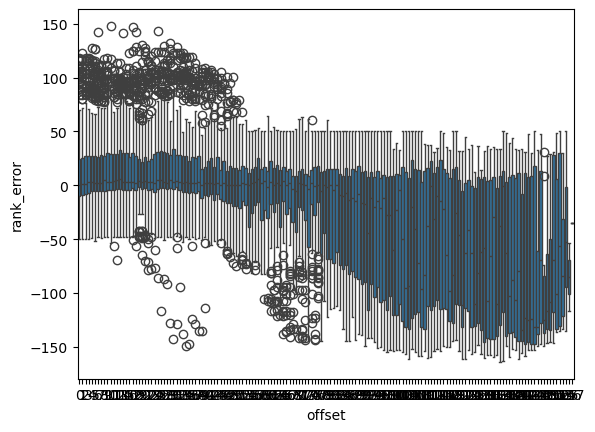

In [289]:
sns.boxplot(df[prediction_set], x='offset', y='rank_error')

SignificanceResult(statistic=0.6268587325817668, pvalue=0.0)


<AxesSubplot: >

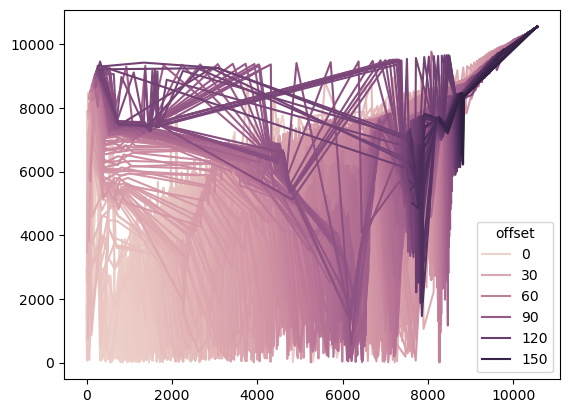

In [290]:
cols = ['Std', 'Absolute Error']
print(scipy.stats.spearmanr(prediction_df[cols[0]], prediction_df[cols[1]]))
sns.lineplot(prediction_df, x=scipy.stats.rankdata(prediction_df[cols[0]]), y=scipy.stats.rankdata(prediction_df[cols[1]]), hue='offset')

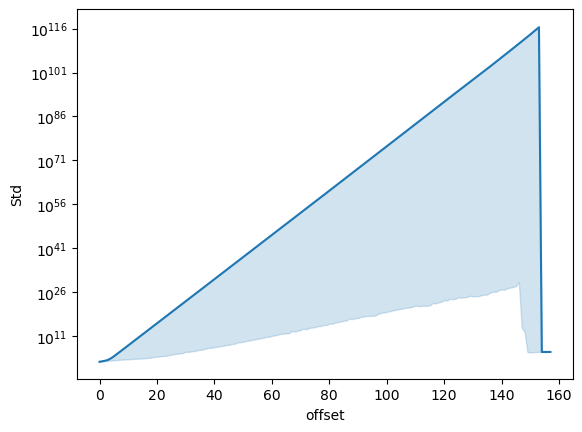

In [291]:
sns.lineplot(prediction_df, x='offset', y='Std')
#plt.ylim(0, 10000)
plt.yscale('log')

<AxesSubplot: xlabel='Observation Z-score', ylabel='Density'>

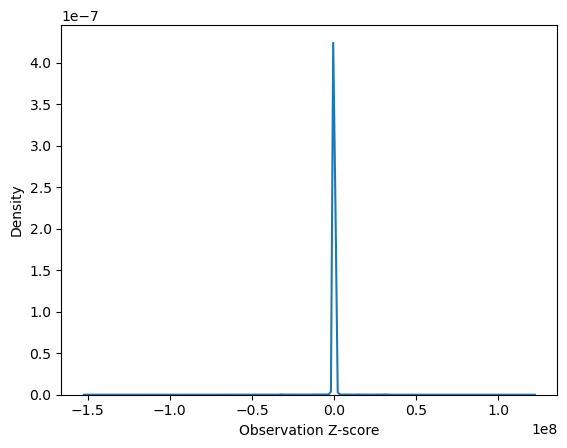

In [292]:
sns.kdeplot(prediction_df, x='Observation Z-score')

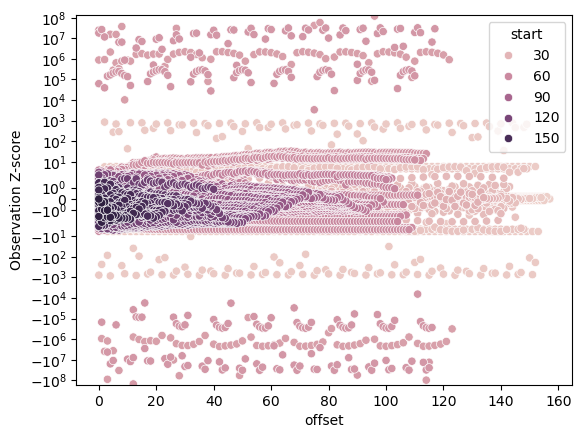

In [293]:
sns.scatterplot(prediction_df, x='offset', y='Observation Z-score', hue='start')
plt.yscale('symlog')

# Log Likelihood of Observations

In [294]:
def std_kernel(t, w):
    return np.sum([w[i]*t**i for i in range(len(w))], axis=0)

def gaussian(x, std=1, mu=0):
    # PDF of gaussian distribution
    return (1/(std*np.sqrt(np.pi*2))*np.exp((-1/2)*(((x-mu)/std)**2)))

def log_gaussian(x, std=1, mu=0):
    # Calculate log probablity directly to get around precision limitations
   # std = np.ma.masked_less_equal(std, 0)
    mask = std<=0
    std = abs(std)

    info = np.finfo(np.float64)
    std[std==0] = info.eps
    #std[mask] = np.nan
    
    logprob =  (-np.log(std) - 0.5*np.log(2*np.pi) - 0.5*(((x-mu)/std)**2))
    #logprob[mask] = -np.inf
    return logprob
  #  return logprob.filled(-np.inf)
    

def maximise_likelihood(w, x, mu, t):
    std = std_kernel(t, w)
    logprobs = log_gaussian(x, std=std, mu=mu)
    
    return -np.sum(logprobs[~np.isinf(logprobs)])

def constrain_std(w, t):
   # t = np.arange(200)
    std = std_kernel(t, w)
    return np.sum(std<=0)

In [296]:
test_df = copy.deepcopy(prediction_df)
test_df = test_df[test_df.offset<10]

In [297]:
logprobs = log_gaussian(test_df['Observed'], std=test_df.Std, mu=test_df['value'])
arma_std_likelihood = np.sum(logprobs[~np.isinf(logprobs)])
print( np.sum(np.isinf(logprobs)))
print( np.sum(logprobs[~np.isinf(logprobs)]))

0
-6656789100440147.0


# Maximising Log-Likelihood

In [453]:
class Prediction_Set():
    def __init__(self, df):
        self.df = df

        self.prediction_set = (self.df.offset >=0)
        self.prediction_df = df[self.prediction_set].dropna()

        self.test_df = copy.deepcopy(self.prediction_df)
        self.test_df = self.test_df[self.test_df.offset<10]

        offset_std = scipy.stats.linregress(self.test_df['offset'], self.test_df['Std'])
        self.w0 = [offset_std.intercept, offset_std.slope,0, 0]

    def optimise_likelihood(self, w0=None, method='Nelder-Mead', verbose=True, plot_path=True):
        if w0 is None:
            w0 = self.w0

        if method=='Differential Evolution':
            self.bound = 10000000
            res = scipy.optimize.differential_evolution(self.maximise_likelihood, 
                                          [(-self.bound, self.bound) for p in w0])
            self.res = Results(res, self)
            self.w0 = res.x                              
        else:
            res = scipy.optimize.minimize(self.maximise_likelihood, 
                                    w0, 
                                    constraints=[{'fun':self.constrain_std, 'args':([self.test_df['offset']]), 'type':'eq'}],
                                    method=method,
                                    options={'maxiter':20000, 'return_all':True})
            self.res = Results(res, self)
            if plot_path:
                self.res.plot_result_path()
                self.w0 = self.res.all_simplex.loc[self.res.all_simplex["Performance"].argmin(), self.res.param_cols]
            
        if verbose:
            print(res)
            
        return res

    def maximise_likelihood(self, w):
        std = std_kernel(self.test_df['offset'], w)
        logprobs = log_gaussian(self.test_df['Observed'], std=std, mu=self.test_df['value'])
        
        return -np.sum(logprobs[~np.isinf(logprobs)])

    def constrain_std(self, w, t):

        std = std_kernel(t, w)
        return np.sum(std<=0)

In [473]:
class Results():
    def __init__(self, res, source):
        self.res = res
        
        
        self.source=source
        

    def plot_result_path(self):
        self.simplex = pd.DataFrame(self.res.allvecs)
        self.param_cols = self.simplex.columns
        
        for i in self.simplex.index:
            self.simplex.loc[i, "Performance"] = self.source.maximise_likelihood(self.simplex.iloc[i][self.param_cols])
        self.all_simplex = self.simplex
        
        g = sns.PairGrid(self.simplex[self.param_cols], corner=True)
        g.map_lower(self.pair_results)
        
        
        plt.tight_layout()
        
            
        g.map_diag(self.performance_diag, performance = self.simplex["Performance"])


    def pair_results(self, x, y, color='C0', label=None, **kwargs):
        plt.gca().plot(x, y, color=color, label=label)
        plt.gca().scatter(x.iloc[-1], y.iloc[-1], marker='*', c='goldenrod', zorder=10)
    
        combo = [x.name, y.name]

        self.interpolate_grid(self.simplex, combo, plt.gca())

    def performance_diag(self, x, color='C0', label=None, **kwargs):
        plt.gca().plot(x, kwargs["performance"])
        plt.gca().set_yscale('log')

    def interpolate_grid(self, simplex, cols, ax):
        yl = ax.get_ylim()
        y = np.linspace(*ax.get_ylim())
        x = np.linspace(*ax.get_xlim())
        [X, Y]=np.meshgrid(x,y)
        new_simplex = pd.DataFrame(index=np.arange(len(X.reshape(-1))), columns=self.param_cols)
        new_simplex[self.param_cols] = self.res.x
        new_simplex[cols[0]] = X.reshape(-1)
        new_simplex[cols[1]] = Y.reshape(-1)
    # print(new_simplex)
        Z = np.zeros_like(X.reshape(-1))
        for i in new_simplex.index:
            Z[i] = self.source.maximise_likelihood(new_simplex.iloc[i])
        found_best = self.res.fun
        levels = np.geomspace(Z.min(), np.quantile(Z, 0.5), num=10)
        levels = np.sort([*levels, found_best, Z.max()])
        c = ax.contourf(X, Y, Z.reshape(X.shape), norm=mpl.colors.LogNorm(vmin=Z.min(), vmax=np.quantile(Z, 0.5)), levels=levels, cmap='YlGnBu')
        plt.colorbar(c)

        Z_best = Z.argmin()
        overall_best = new_simplex.iloc[Z_best]
        ax.title.set_text(f"L* = {Z[Z_best]:.2f}, (Grid Search)")
        if Z[Z_best] > found_best:
            overall_best = self.res.x
            ax.title.set_text(f"L* = {found_best:.2f}, (Algorithm)")
        
        ax.scatter(new_simplex[cols[0]], new_simplex[cols[1]], s=5, c='w', alpha=0.1)
        ax.scatter(overall_best[cols[0]], overall_best[cols[1]], marker='*', c='r')

        new_simplex['Performance'] = Z
        
        self.all_simplex = pd.concat([self.all_simplex, new_simplex]).reset_index(drop=True)

In [455]:
price = Prediction_Set(df)
volume = Prediction_Set(vol_df)



In [456]:
res = price.optimise_likelihood(method='Differential Evolution')
res_vol = volume.optimise_likelihood(method='Differential Evolution')

             message: Optimization terminated successfully.
             success: True
                 fun: 22356.201622629458
                   x: [ 5.797e+02  5.340e+06 -6.672e+06  1.332e+06]
                 nit: 31
                nfev: 2370
          population: [[ 4.209e+04  5.309e+06 -6.705e+06  1.332e+06]
                       [-3.536e+05  4.867e+06 -5.203e+06  8.434e+05]
                       ...
                       [-9.590e+05  6.824e+06 -6.690e+06  1.308e+06]
                       [-1.273e+04  6.256e+06 -5.271e+06  1.114e+06]]
 population_energies: [ 2.236e+04  2.424e+04 ...  2.443e+04  2.375e+04]
                 jac: [ 0.000e+00  3.551e-04  0.000e+00  3.634e-04]
             message: Optimization terminated successfully.
             success: True
                 fun: 485696.9401098797
                   x: [-7.822e+06 -9.827e+06 -9.899e+06 -1.000e+07]
                 nit: 24
                nfev: 1555
          population: [[-7.822e+06 -9.827e+06 -9.900e+06 -9.9

In [476]:
volume.maximise_likelihood(volume.w0)

31536.50024724853

In [475]:
volume.res.res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 31536.50024724853
             x: [-2.045e+03  5.312e+08 -2.260e+08 -3.052e+08]
           nit: 694
          nfev: 1256
 final_simplex: (array([[-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       ...,
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08]]), array([ 3.154e+04,  3.154e+04,  3.154e+04,  3.154e+04,
                        3.154e+04]))
       allvecs: [array([-7.822e+06, -9.827e+06, -9.899e+06, -1.000e+07]), array([-7.822e+06, -9.827e+06, -9.899e+06, -1.050e+07]), array([-7.822e+06, -9.827e+06, -9.899e+06, -1.050e+07]), array([-7.749e+06, -9.305e+06, -1.073e+07, -1.084e+07]), array([-7.694e+06, -9.896e+06, -9.999e+06, -1.148e+07]), array([-7.694e+06, -9.896e+06, -9.999e+06, -1.148e+07

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\1261062617.py:25: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 22254.71692392296
             x: [ 5.798e+02  3.715e+06 -4.641e+06  9.256e+05]
           nit: 272
          nfev: 524
 final_simplex: (array([[ 5.798e+02,  3.715e+06, -4.641e+06,  9.256e+05],
                       [ 5.798e+02,  3.715e+06, -4.641e+06,  9.256e+05],
                       ...,
                       [ 5.798e+02,  3.715e+06, -4.641e+06,  9.256e+05],
                       [ 5.798e+02,  3.715e+06, -4.641e+06,  9.256e+05]]), array([ 2.225e+04,  2.225e+04,  2.225e+04,  2.225e+04,
                        2.225e+04]))
       allvecs: [array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]), array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]), array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]), array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]), array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]), array([ 5.797e+02,  5.340e+06, -6.672e+06,  1.332e+06]

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\1261062617.py:25: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 31536.50024724853
             x: [-2.045e+03  5.312e+08 -2.260e+08 -3.052e+08]
           nit: 694
          nfev: 1256
 final_simplex: (array([[-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       ...,
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08],
                       [-2.045e+03,  5.312e+08, -2.260e+08, -3.052e+08]]), array([ 3.154e+04,  3.154e+04,  3.154e+04,  3.154e+04,
                        3.154e+04]))
       allvecs: [array([-7.822e+06, -9.827e+06, -9.899e+06, -1.000e+07]), array([-7.822e+06, -9.827e+06, -9.899e+06, -1.050e+07]), array([-7.822e+06, -9.827e+06, -9.899e+06, -1.050e+07]), array([-7.749e+06, -9.305e+06, -1.073e+07, -1.084e+07]), array([-7.694e+06, -9.896e+06, -9.999e+06, -1.148e+07]), array([-7.694e+06, -9.896e+06, -9.999e+06, -1.148e+07

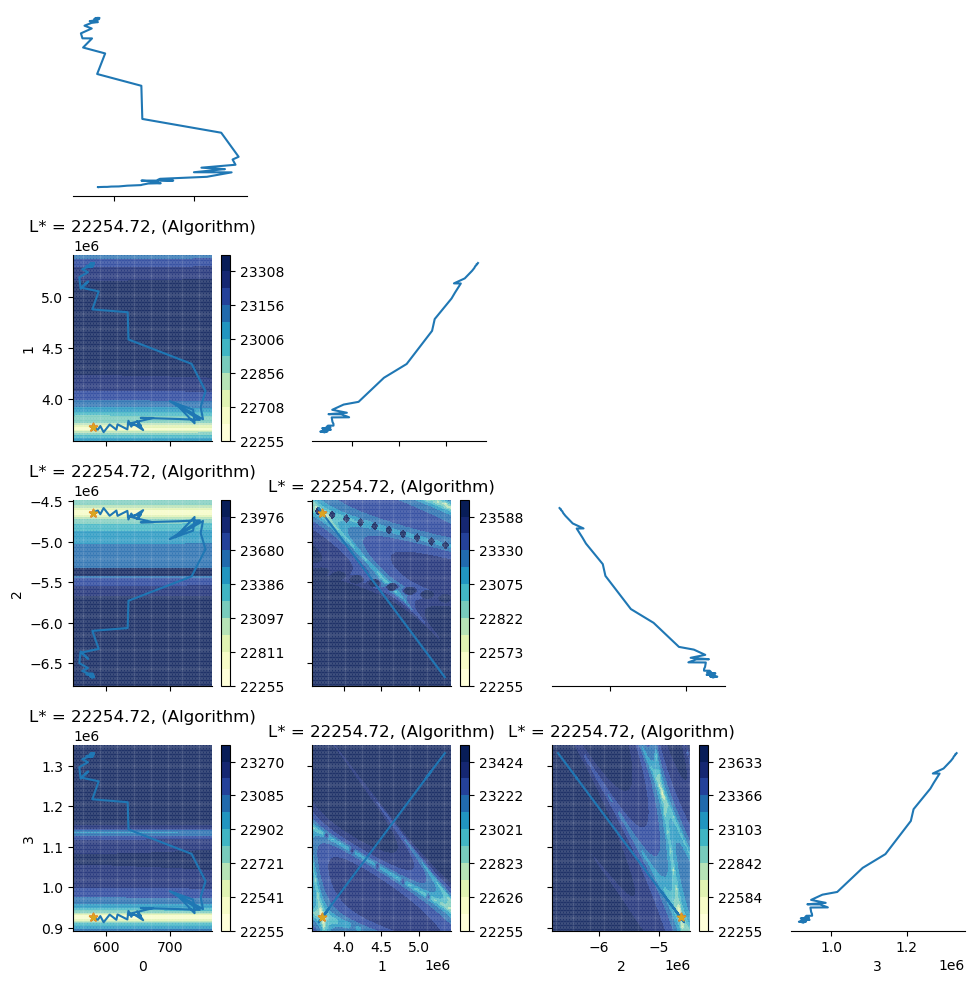

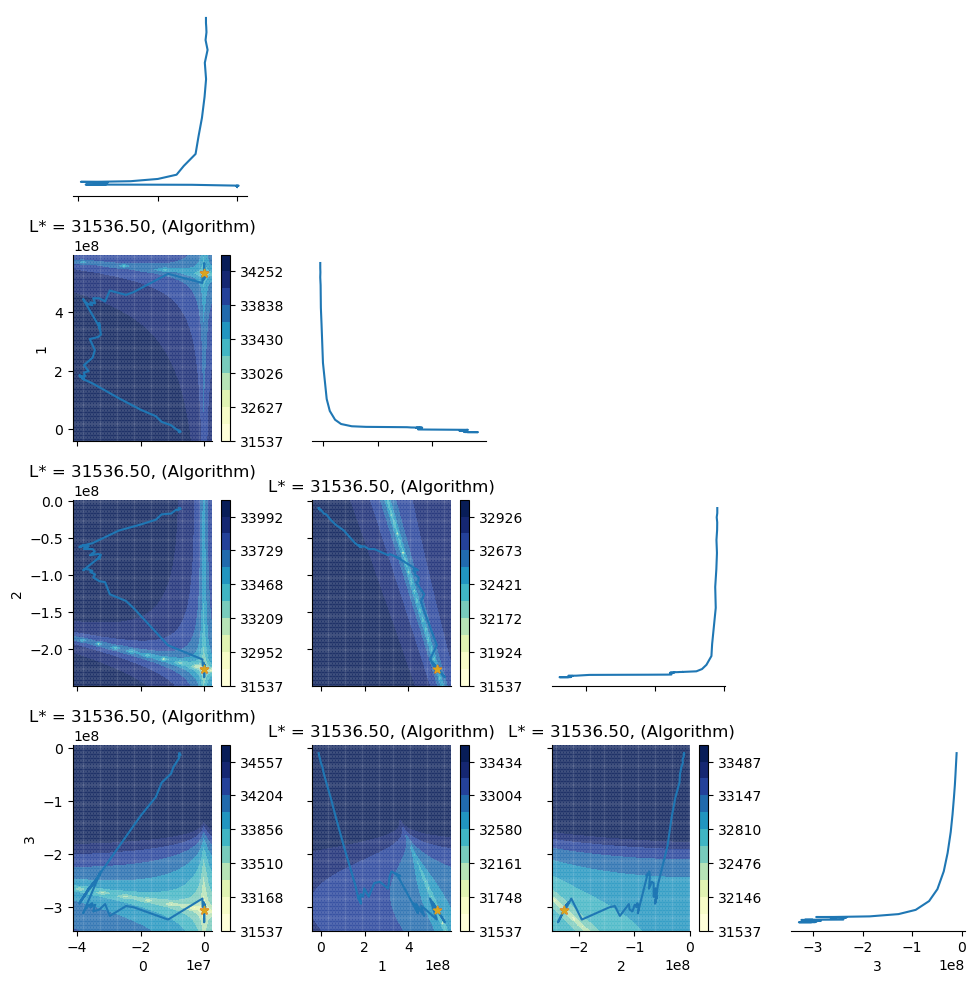

In [474]:
res1 = price.optimise_likelihood(w0=res.x)
res_vol1 = volume.optimise_likelihood(w0=res_vol.x)

In [472]:
volume.maximise_likelihood(volume.w0)

485696.9401098797

In [471]:
volume.w0

0   -7.822189e+06
1   -9.827182e+06
2   -9.898681e+06
3   -1.000000e+07
Name: 0, dtype: float64

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\981276259.py:24: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 22072.57974502475
             x: [ 5.798e+02  2.292e+06 -3.058e+06  7.654e+05]
           nit: 150
          nfev: 303
 final_simplex: (array([[ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       ...,
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]]), array([ 2.207e+04,  2.207e+04,  2.207e+04,  2.207e+04,
                        2.207e+04]))
       allvecs: [array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\981276259.py:24: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 31487.1223754421
             x: [ 2.045e+03 -3.626e+08  3.033e+07  3.322e+08]
           nit: 740
          nfev: 1348
 final_simplex: (array([[ 2.045e+03, -3.626e+08,  3.033e+07,  3.322e+08],
                       [ 2.045e+03, -3.626e+08,  3.033e+07,  3.322e+08],
                       ...,
                       [ 2.045e+03, -3.626e+08,  3.033e+07,  3.322e+08],
                       [ 2.045e+03, -3.626e+08,  3.033e+07,  3.322e+08]]), array([ 3.149e+04,  3.149e+04,  3.149e+04,  3.149e+04,
                        3.149e+04]))
       allvecs: [array([ 9.664e+06,  9.526e+06,  9.965e+06,  1.000e+07]), array([ 9.664e+06,  9.526e+06,  9.965e+06,  1.050e+07]), array([ 9.664e+06,  9.526e+06,  9.965e+06,  1.050e+07]), array([ 9.573e+06,  9.020e+06,  1.081e+07,  1.084e+07]), array([ 9.505e+06,  9.593e+06,  1.007e+07,  1.148e+07]), array([ 9.505e+06,  9.593e+06,  1.007e+07,  1.148e+07]

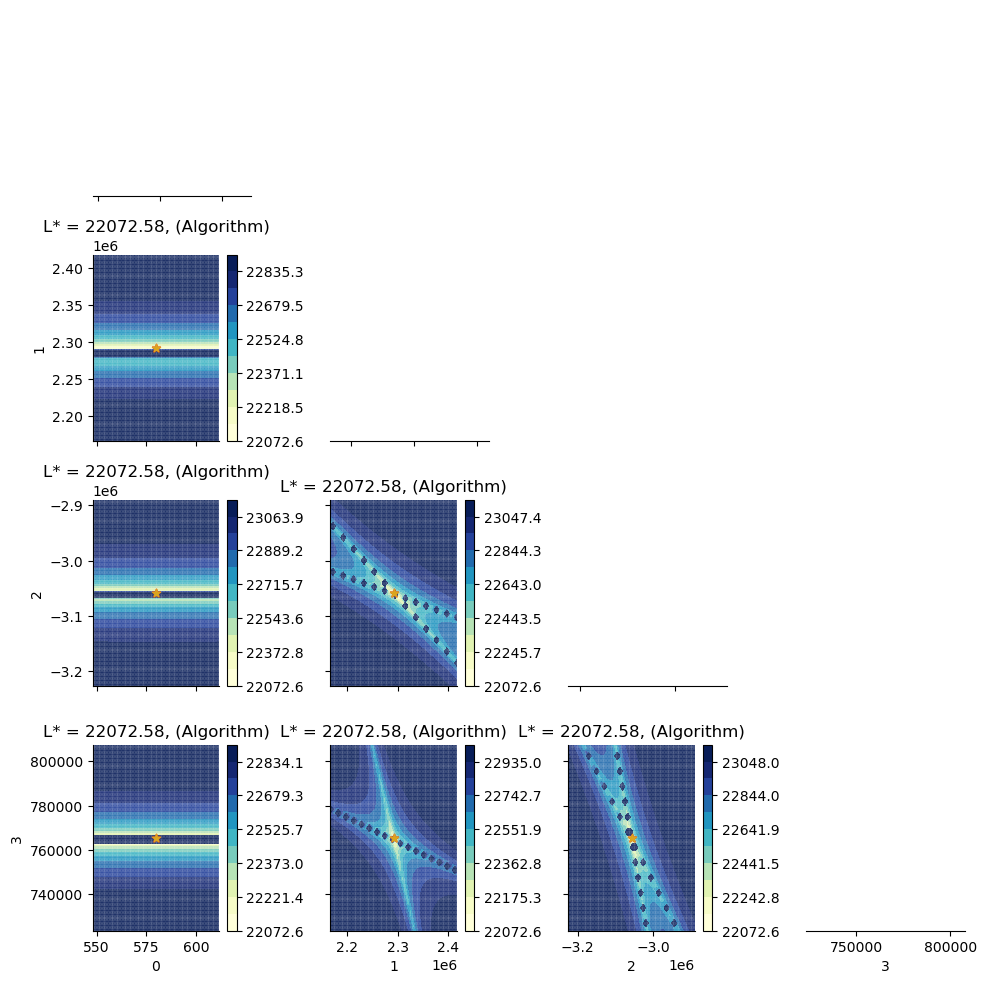

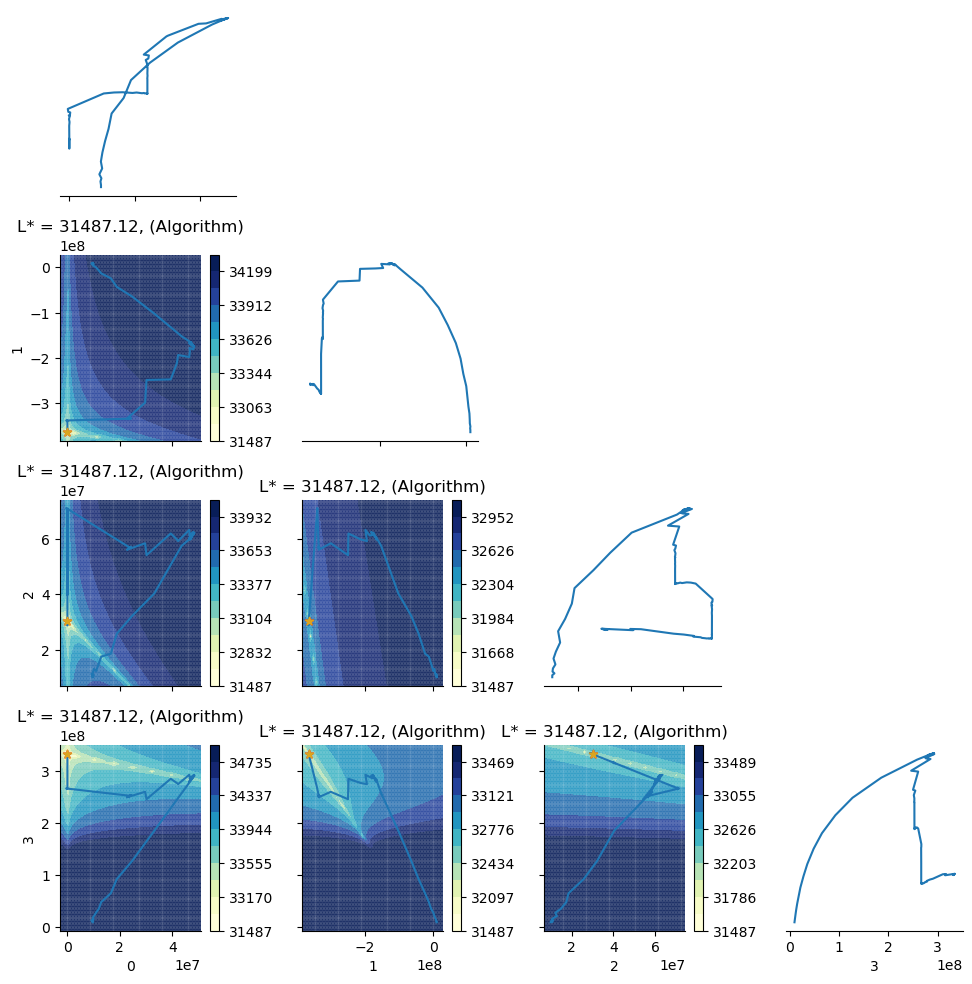

In [420]:
res2 = price.optimise_likelihood()
res_vol2 = volume.optimise_likelihood()

In [445]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

model = pyo.AbstractModel()
model.name = 'Likelihood Maximisation'

# note boundaries of variables and initial condition $x_0=[-2,2]$
model.x1 = pyo.Var(bounds=(-2,3), initialize=-2)
model.x2 = pyo.Var(bounds=(-2,2), initialize=2)
model.x3 = pyo.Var(bounds=(-2,3), initialize=-2)
model.x4 = pyo.Var(bounds=(-2,2), initialize=2)

def rosenbrock(model):
    f = (1.0-model.x1)**2 + 100.0*(model.x2 - model.x1**2)**2
    return f

def ineqconstr(model):
    return model.x2 >= model.x1+1

model.obj = pyo.Objective(rule=rosenbrock, sense=pyo.minimize)
model.constraint = pyo.Constraint(rule=ineqconstr)

In [448]:
import io
 
# declare a dummy file
dummy_file = io.StringIO() #we create a in-memory text stream

# create an instance of the problem
maxlikeproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
maxlikeproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(maxlikeproblem, tee=True, logfile = "name.csv") 

# show results

maxlikeproblem.display(ostream=dummy_file)

    cplex


ApplicationError: No executable found for solver 'cplex'

In [424]:
volume.res.all_simplex.sort_values('Performance')[:500]

,0,1,2,3,Performance
0,9.663534e+06,9.525947e+06,9.965121e+06,1.000000e+07,29288.335834
1,9.663534e+06,9.525947e+06,9.965121e+06,1.050000e+07,29331.965056
2,9.663534e+06,9.525947e+06,9.965121e+06,1.050000e+07,29331.965056
3,9.572938e+06,9.019881e+06,1.080593e+07,1.084375e+07,29372.343010
4,9.504991e+06,9.592926e+06,1.006633e+07,1.147656e+07,29412.098247
...,...,...,...,...,...
629,2.047180e+03,-3.625536e+08,3.035925e+07,3.321861e+08,30347.054588
630,2.047180e+03,-3.625536e+08,3.035925e+07,3.321861e+08,30347.054588
624,2.048410e+03,-3.625761e+08,3.032230e+07,3.322456e+08,30347.100077
627,2.048410e+03,-3.625761e+08,3.032230e+07,3.322456e+08,30347.100077


In [430]:
def plot_boundaries(x, y, color=None, label=None):
    bound = 10000000
    plt.gca().axhspan(ymin=-bound, ymax=bound, xmin=-bound, xmax=bound)

In [303]:


def optimise_likelihood(w0=[offset_std.intercept, offset_std.slope,0, 0],method='Nelder-Mead', test_df=test_df):
    res = scipy.optimize.minimize(maximise_likelihood, 
                            w0, 
                            args=(test_df['Observed'], test_df['value'], test_df['offset']), 
                            constraints=[{'fun':constrain_std, 'args':([test_df['offset']]), 'type':'eq'}],
                            method=method,
                            options={'maxiter':20000, 'return_all':True})
    return res


def differential_ev(w = [offset_std.intercept, offset_std.slope,0, 0], test_df=test_df):
    res = scipy.optimize.differential_evolution(maximise_likelihood, 
                                          [(-1000000, 1000000) for p in w], 
                                          args = (test_df['Observed'], test_df['value'], test_df['offset']))
                                          
    return res

res_df = differential_ev()

res = optimise_likelihood(res_df.x, method='Powell')
print(res)
res1 = optimise_likelihood(res.x)
#res2 = optimise_likelihood(res1.x, method='Powell')


C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2353541477.py:4: RuntimeWarning: Method Powell cannot handle constraints.
  res = scipy.optimize.minimize(maximise_likelihood,
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2353541477.py:4: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(maximise_likelihood,


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 23130.281479341116
       x: [-5.797e+02 -5.680e+05 -8.448e+05  5.651e+05]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 33
 allvecs: [array([-5.799e+02, -5.680e+05, -8.448e+05,  5.651e+05]), array([-5.797e+02, -5.680e+05, -8.448e+05,  5.651e+05])]


In [304]:
vol_res = differential_ev(test_df=vol_df)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply

In [305]:
print(vol_res)

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 7.598941183732872e+293
                   x: [ 1.000e+06  1.000e+06  1.000e+06  1.000e+06]
                 nit: 1000
                nfev: 60065
          population: [[ 1.000e+06  1.000e+06  1.000e+06  1.000e+06]
                       [ 1.000e+06  1.000e+06  1.000e+06  1.000e+06]
                       ...
                       [ 1.000e+06  1.000e+06  1.000e+06  1.000e+06]
                       [ 1.000e+06  1.000e+06  1.000e+06  1.000e+06]]
 population_energies: [ 7.599e+293  7.599e+293 ...  7.599e+293  7.599e+293]


In [301]:
import itertools

def plot_result_path(res):
    simplex = pd.DataFrame(res.allvecs)
    param_cols = simplex.columns
    
    g = sns.PairGrid(simplex[param_cols], corner=True)
    g.map_lower(pair_results, simplex=simplex[param_cols])
    
    all_simplex = simplex
    plt.tight_layout()
    for i in simplex.index:
        simplex.loc[i, "Performance"] = maximise_likelihood(simplex.iloc[i][param_cols], test_df['Observed'], test_df['value'], test_df['offset'])
        all_simplex.concat(new_simplex)
    g.map_diag(performance_diag, performance = simplex["Performance"])
    #fig, ax = plt.subplots()
    #ax.plot(simplex.index, simplex.Performance)
    #ax.set_yscale('log')

def pair_results(x, y, color='C0', label=None, **kwargs):
    plt.gca().plot(x, y, color=color, label=label)
    plt.gca().scatter(x.iloc[-1], y.iloc[-1], marker='*', c='goldenrod', zorder=10)
   
    combo = [x.name, y.name]
    #combo[0] = simplex.columns[simplex.eq(x,axis=0).all()][0]
    #combo[1] = simplex.columns[simplex.eq(y,axis=0).all()][0]
    interpolate_grid(kwargs['simplex'], combo, plt.gca())

def performance_diag(x, color='C0', label=None, **kwargs):
    plt.gca().plot(x, kwargs["performance"])
    plt.gca().set_yscale('log')

def interpolate_grid(simplex, cols, ax):
    yl = ax.get_ylim()
    y = np.linspace(*ax.get_ylim())
    x = np.linspace(*ax.get_xlim())
    [X, Y]=np.meshgrid(x,y)
    new_simplex = pd.DataFrame(index=np.arange(len(X.reshape(-1))), columns=simplex.columns)
    new_simplex[simplex.columns] = simplex.iloc[-1]
    new_simplex[cols[0]] = X.reshape(-1)
    new_simplex[cols[1]] = Y.reshape(-1)
   # print(new_simplex)
    Z = np.zeros_like(X.reshape(-1))
    for i in new_simplex.index:
        Z[i] = maximise_likelihood(new_simplex.iloc[i], test_df['Observed'], test_df['value'], test_df['offset'])
    found_best = maximise_likelihood(simplex.iloc[-1], test_df['Observed'], test_df['value'], test_df['offset'])
    levels = np.geomspace(Z.min(), np.quantile(Z, 0.5), num=10)
    levels = np.sort([*levels, found_best, Z.max()])
    c = ax.contourf(X, Y, Z.reshape(X.shape), norm=mpl.colors.LogNorm(vmin=Z.min(), vmax=np.quantile(Z, 0.5)), levels=levels, cmap='bone')
    plt.colorbar(c)

    Z_best = Z.argmin()
    overall_best = new_simplex.iloc[Z_best]
    ax.title.set_text(f"L* = {Z[Z_best]:.2f}, (Grid Search)")
    if Z[Z_best] > found_best:
        overall_best = simplex.iloc[-1]
        ax.title.set_text(f"L* = {found_best:.2f}, (Algorithm)")
    
    ax.scatter(new_simplex[cols[0]], new_simplex[cols[1]], s=5, c='w', alpha=0.1)
    ax.scatter(overall_best[cols[0]], overall_best[cols[1]], marker='*', c='r')

    new_simplex['Performance'] = Z
    return new_simplex, overall_best

#fig, ax = plt.subplot()
#sns.scatterplot()

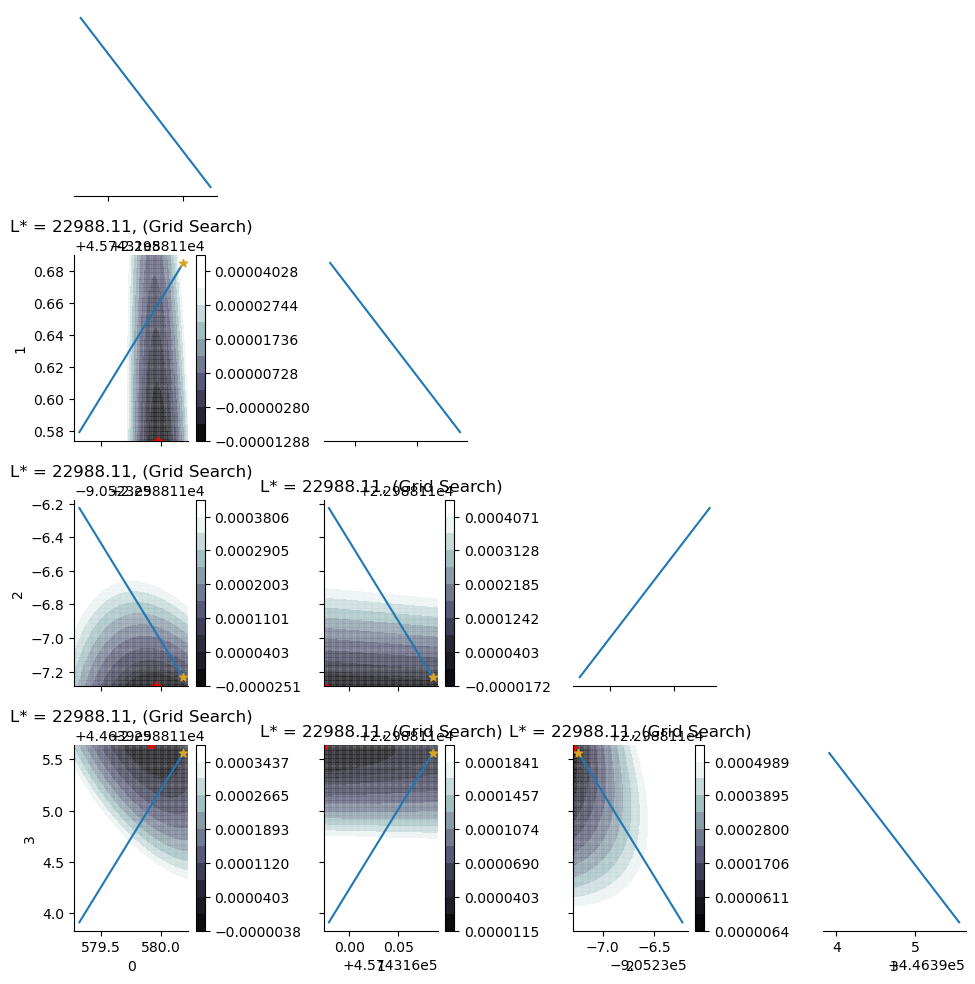

In [302]:
plot_result_path(res)

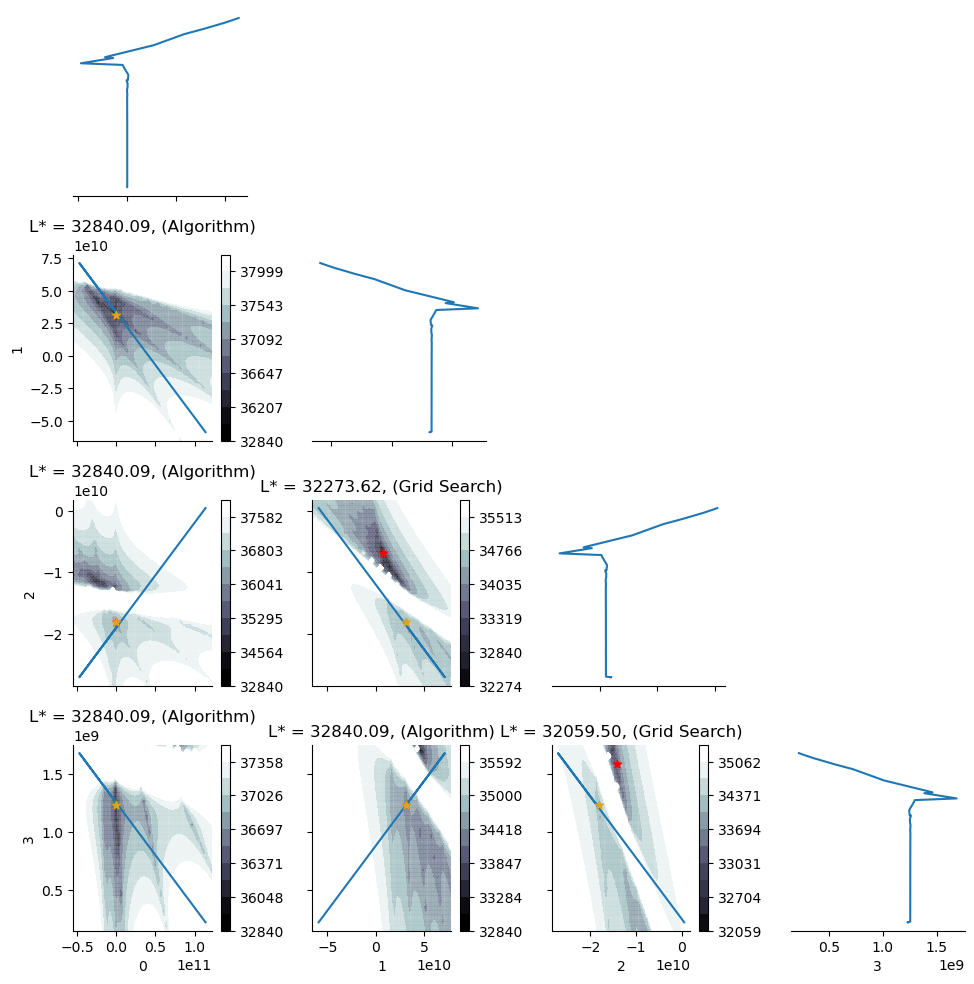

In [284]:
plot_result_path(res1)

In [29]:
-res1.fun-arma_std_likelihood

6656789100418052.0

# Comparing Z-scores of observations

In [450]:
price.w0
price.maximise_likelihood(price.w0)

2028592.7999951148

In [452]:
price.w0

[-1980418.3693398943, 778740.97600929, 0, 0]

In [451]:
res2

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 22072.57974502475
             x: [ 5.798e+02  2.292e+06 -3.058e+06  7.654e+05]
           nit: 150
          nfev: 303
 final_simplex: (array([[ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       ...,
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05],
                       [ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]]), array([ 2.207e+04,  2.207e+04,  2.207e+04,  2.207e+04,
                        2.207e+04]))
       allvecs: [array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]), array([ 5.798e+02,  2.292e+06, -3.058e+06,  7.654e+05]

In [30]:
test_df["Optimised Std"] = std_kernel(test_df['offset'], res1.x)
test_df["New Z-score"] = (test_df["Observed"]-test_df['value'])/test_df['Optimised Std'] 

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score
686,14,-1.243484e+02,1.067423e+03,4.715373e+02,14,0,14,1600.000,77.0,36.5,-1.128463e+03,40.5,1.128463e+03,40.5,304.023313,3.711764,1600.0,False,-5.799246e+02,-1.945878
687,15,7.195972e+03,1.363502e+04,1.041550e+04,14,1,15,1600.000,92.0,36.5,8.815497e+03,55.5,8.815497e+03,55.5,1642.615078,-5.366746,1600.0,True,8.298122e+02,-10.623485
688,16,-7.156474e+04,-3.407917e+04,-5.282195e+04,14,2,16,1600.000,76.0,36.5,-5.442195e+04,39.5,5.442195e+04,39.5,9562.644139,5.691099,1600.0,False,4.636008e+03,11.738970
689,17,2.090931e+05,4.191917e+05,3.141424e+05,14,3,17,1660.000,93.0,49.0,3.124824e+05,44.0,3.124824e+05,44.0,53596.566114,-5.830269,1600.0,True,3.943454e+06,-0.079241
690,18,-2.352902e+06,-1.173130e+06,-1.763016e+06,14,4,18,1654.165,75.0,48.0,-1.764670e+06,27.0,1.764670e+06,27.0,300962.394962,5.863424,1600.0,False,1.574990e+07,0.112043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19115,131,4.869456e+03,6.587289e+03,5.728373e+03,123,8,131,4350.000,131.0,116.0,1.378373e+03,15.0,1.378373e+03,15.0,438.222575,-3.145371,4950.0,True,2.203043e+08,-0.000006
19116,132,4.923808e+03,6.838428e+03,5.881118e+03,123,9,132,4350.000,133.0,116.0,1.531118e+03,17.0,1.531118e+03,17.0,488.423536,-3.134817,4950.0,True,3.304381e+08,-0.000005
19278,126,4.513464e+03,5.484795e+03,4.999130e+03,124,2,126,4225.000,122.0,113.0,7.741299e+02,9.0,7.741299e+02,9.0,247.788502,-3.124156,4500.0,True,4.636008e+03,-0.166982
23502,150,4.737931e+03,5.591714e+03,5.164823e+03,149,1,150,4500.000,149.0,124.5,6.648226e+02,24.5,6.648226e+02,24.5,217.801606,-3.052423,5000.0,True,8.298122e+02,-0.801172


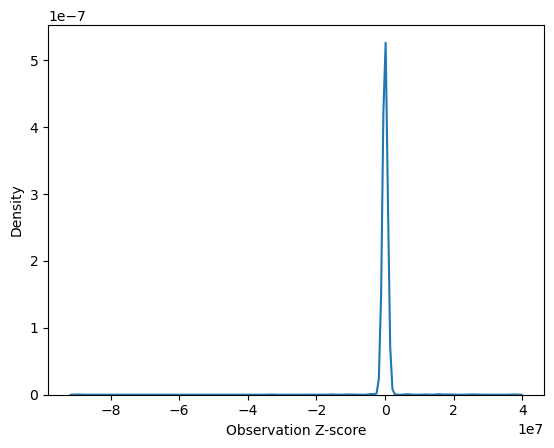

In [31]:
sns.kdeplot(test_df, x='Observation Z-score')
test_df[abs(test_df["Observation Z-score"])>3]

<AxesSubplot: xlabel='New Z-score', ylabel='Density'>

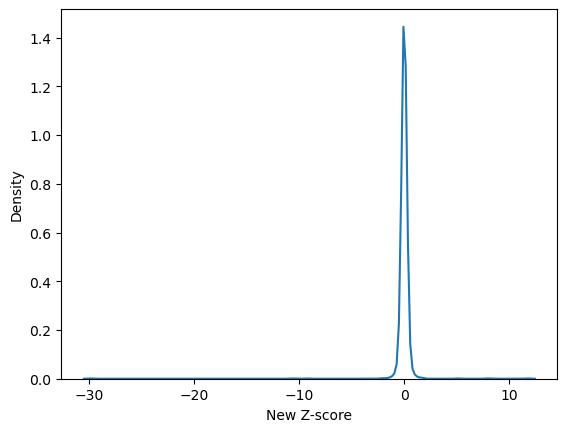

In [32]:
sns.kdeplot(test_df, x='New Z-score')

In [33]:
test_df[abs(test_df["New Z-score"])>3]

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score
687,15,7.195972e+03,1.363502e+04,1.041550e+04,14,1,15,1600.0,92.0,36.5,8.815497e+03,55.5,8.815497e+03,55.5,1.642615e+03,-5.366746e+00,1600.0,True,8.298122e+02,-10.623485
688,16,-7.156474e+04,-3.407917e+04,-5.282195e+04,14,2,16,1600.0,76.0,36.5,-5.442195e+04,39.5,5.442195e+04,39.5,9.562644e+03,5.691099e+00,1600.0,False,4.636008e+03,11.738970
694,22,-2.339851e+09,-1.168607e+09,-1.754229e+09,14,8,22,1648.5,73.0,40.0,-1.754230e+09,33.0,1.754230e+09,33.0,2.987868e+08,5.871177e+00,1600.0,False,2.203043e+08,7.962761
695,23,6.560588e+09,1.313603e+10,9.848312e+09,14,9,23,1690.0,96.0,50.0,9.848310e+09,46.0,9.848310e+09,46.0,1.677410e+09,-5.871141e+00,1600.0,True,3.304381e+08,-29.803796
855,15,4.588532e+03,4.603713e+03,4.596122e+03,15,0,15,1600.0,92.0,36.5,2.996122e+03,55.5,2.996122e+03,55.5,3.872536e+00,-7.736848e+02,1600.0,True,-5.799246e+02,5.166400
6432,48,-3.974307e+03,-3.974306e+03,-3.974306e+03,48,0,48,1400.0,60.0,20.5,-5.374306e+03,39.5,5.374306e+03,39.5,2.145832e-04,2.504533e+07,1100.0,False,-5.799246e+02,-9.267250


# Prediction Improvement

In [38]:
test_df["Start Z-score"] = (test_df["Start Observed"]-test_df['value'])/test_df['Optimised Std'] 
test_df["Observed Higher"] = test_df["Observed"] > test_df["Start Observed"]

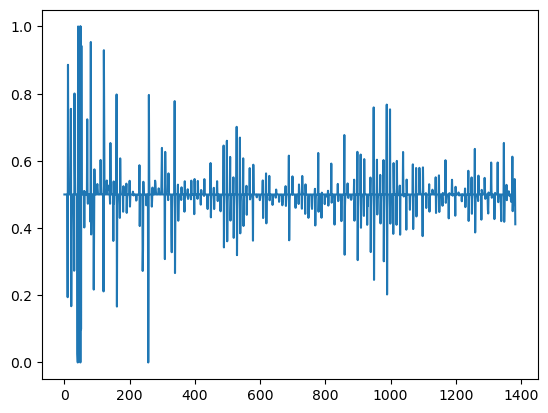

In [41]:
plt.plot(scipy.stats.norm.cdf(test_df["Start Z-score"]))

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

def make_confusion_matrix(obs, pred):
    conf_matrix = confusion_matrix(obs, pred)

    sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')

    RocCurveDisplay.from_predictions(obs, pred)

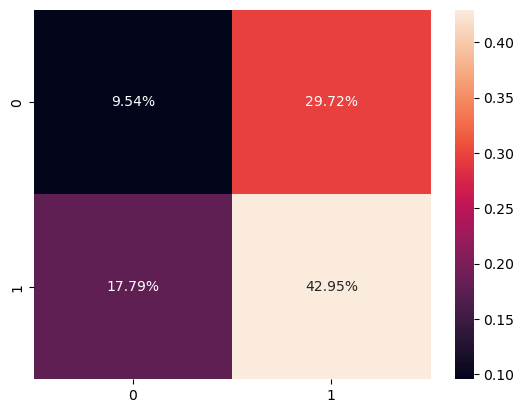

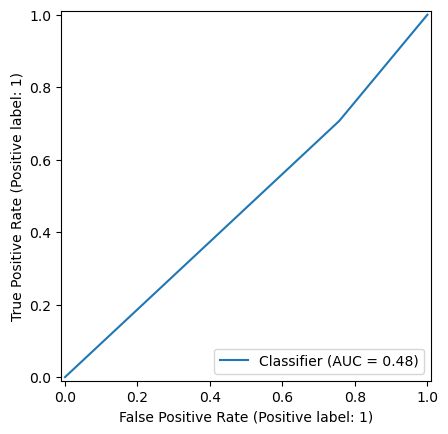

In [61]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Higher'])

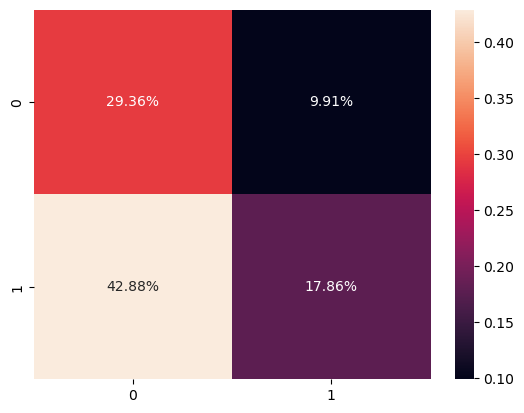

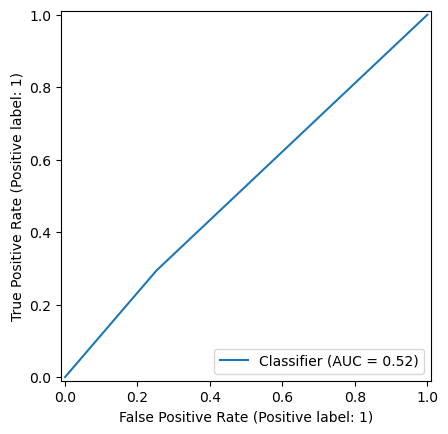

In [62]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Start Z-score']>0)

(-3.0, 3.0)

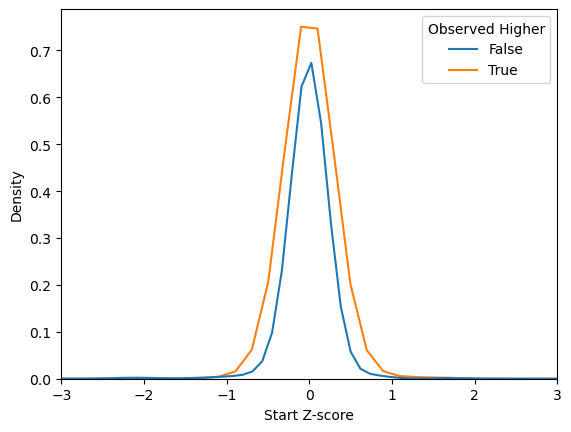

In [51]:
sns.kdeplot(test_df, hue='Observed Higher', x='Start Z-score')
plt.xlim(-3, 3)

In [221]:
hist, edges = np.histogram(test_df.loc[test_df['Observed Higher'], 'Start Z-score'], range=(-1, 1), bins=50)
hist2, _ =np.histogram(test_df.loc[~test_df['Observed Higher'], 'Start Z-score'], bins=edges)

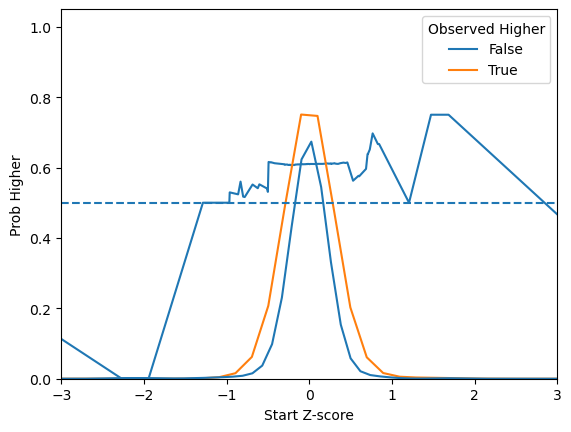

In [237]:
dist = 0.5
test_df["Prob Higher"] = test_df.apply(lambda x: test_df.loc[abs(test_df['Start Z-score']-x['Start Z-score'])<dist, 'Observed Higher'].mean(), axis=1)




sns.lineplot(test_df, x='Start Z-score', y='Prob Higher')
plt.xlim(-3, 3)

sns.kdeplot(test_df, hue='Observed Higher', x='Start Z-score')

plt.axhline(0.5, ls='--')

In [267]:
zscores = np.linspace(-3, 3)

zscore_df = pd.DataFrame(columns=['Z-Score', 'Probability Higher'])
zscore_df['Z-Score'] = zscores
zscore_df["Probability Higher"] = zscore_df.apply(lambda zscore:test_df.loc[train].loc[(abs(test_df['Start Z-score']-zscore['Z-Score'])<dist), 'Observed Higher'].mean(), axis=1)

zscore_df["Probability Higher"] = zscore_df.apply(lambda zscore:np.average(test_df.loc[train,'Observed Higher'], weights=1/abs(test_df.loc[train, 'Start Z-score']-zscore['Z-Score'])**2), axis=1)

(-3.0, 3.0)

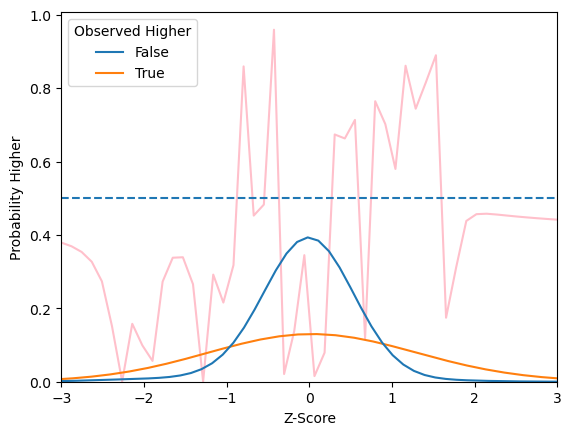

In [269]:
sns.lineplot(zscore_df, x='Z-Score', y='Probability Higher', c='pink')
sns.kdeplot(test_df.loc[train], hue='Observed Higher', x='Start Z-score')

plt.axhline(0.5, ls='--')
plt.xlim(-3, 3)


C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2638970641.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(centers, hist2/(hist+hist2))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2638970641.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(centers, hist/(hist+hist2))


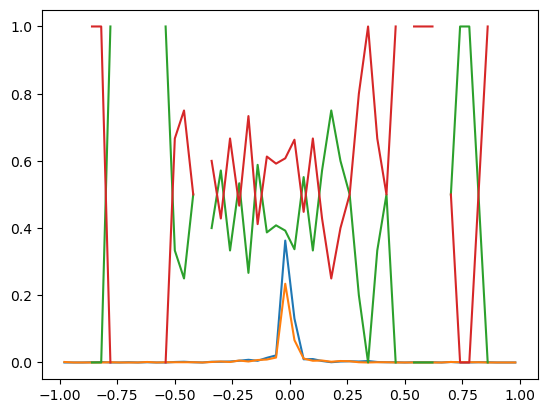

In [222]:
centers = (edges[1:] + edges[:-1])/2

plt.plot(centers, hist/np.sum(hist+hist2))
plt.plot(centers, hist2/np.sum(hist2+hist))
plt.plot(centers, hist2/(hist+hist2))
plt.plot(centers, hist/(hist+hist2))

In [220]:
test_df['Start Z-score'].std()

0.9871383304614405

<AxesSubplot: xlabel='Observed Higher', ylabel='Start Z-score'>

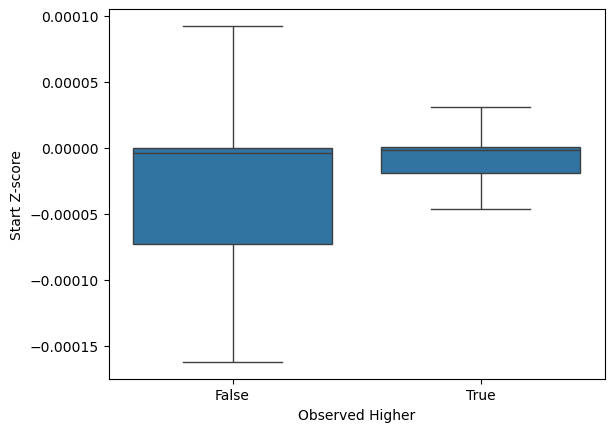

In [49]:
sns.boxplot(test_df, x='Observed Higher', y='Start Z-score', showfliers=False)

(-3.0, 3.0)

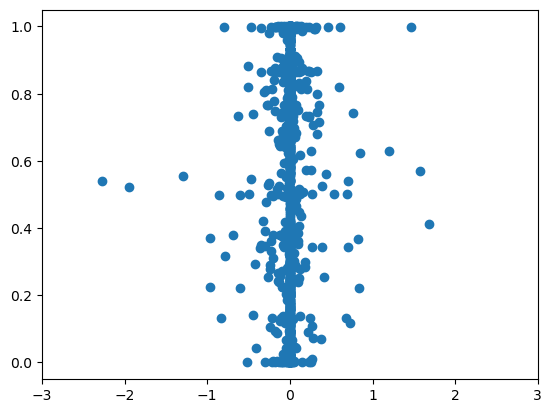

In [184]:
z_rolling =test_df.rolling(2000, on='Start Z-score', center=True, min_periods=0, win_type='gaussian')
higher_prob = z_rolling.mean(std=3)['Observed Higher'].dropna()

plt.scatter(test_df.loc[higher_prob.index, 'Start Z-score'], higher_prob)
plt.xlim(-3, 3)

In [182]:
bins = np.linspace(-1, 1)


,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,...,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score,Start Z-score,Observed Higher
10,10,-75.687426,4075.687426,2000.000000,10,0,10,1500.000000,83.0,29.5,...,500.000000,53.5,1059.024197,-0.472133,2000.0,False,-5.799246e+02,0.862181,-0.000000,False
11,11,-2207.247631,6207.247631,2000.000000,10,1,11,1900.000000,83.0,58.0,...,100.000000,25.0,2146.554914,-0.046586,2000.0,False,8.298122e+02,-0.120509,0.000000,False
12,12,-4411.817367,8411.817367,2000.000000,10,2,12,1550.000000,83.0,33.0,...,450.000000,50.0,3271.335391,-0.137559,2000.0,False,4.636008e+03,-0.097066,0.000000,False
13,13,-6687.573032,10687.573032,2000.000000,10,3,13,1600.000000,83.0,36.5,...,400.000000,46.5,4432.435220,-0.090244,2000.0,False,3.943454e+06,-0.000101,0.000000,False
14,14,-9032.793902,13032.793902,2000.000000,10,4,14,1600.000000,83.0,36.5,...,400.000000,46.5,5628.976481,-0.071061,2000.0,False,1.574990e+07,-0.000025,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,4241.088122,5090.833684,4665.960903,165,1,166,4630.000000,137.0,137.0,...,35.960903,0.0,216.771827,-0.165893,4600.0,True,8.298122e+02,-0.043336,-0.079489,True
26207,167,4075.376597,5046.605095,4560.990846,165,2,167,4499.970344,133.0,118.0,...,61.020503,15.0,247.762372,-0.246286,4600.0,False,4.636008e+03,-0.013162,0.008414,False
26374,166,4340.910318,5022.584046,4681.747182,166,0,166,4630.000000,138.0,137.0,...,51.747182,1.0,173.896359,-0.297575,4615.0,True,-5.799246e+02,0.089231,0.115096,True
26375,167,4149.303170,4995.698088,4572.500629,166,1,167,4499.970344,133.0,118.0,...,72.530285,15.0,215.917071,-0.335917,4615.0,False,8.298122e+02,-0.087406,0.051216,False


<AxesSubplot: xlabel='Higher', ylabel='Start Z-score'>

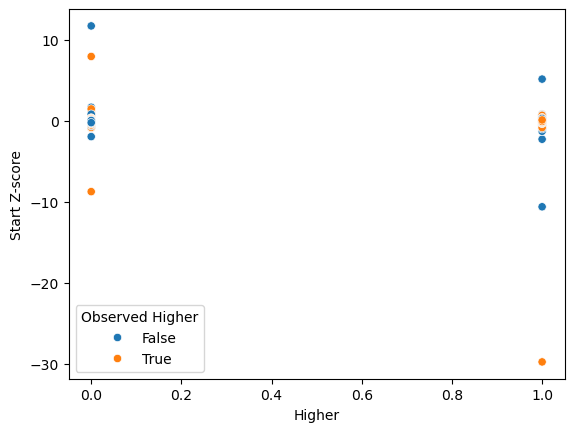

In [65]:
sns.scatterplot(test_df, x='Higher', y='Start Z-score', hue='Observed Higher')

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


(-3.0, 3.0)

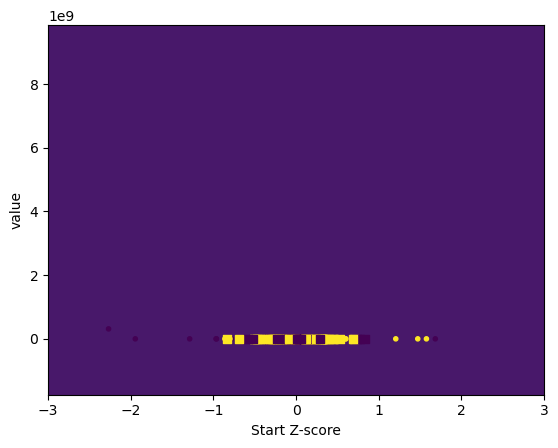

In [159]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split

n = 50
train = np.random.choice(test_df.index, n, replace=False)
train = test_df.index[test_df.period < n]
test = ~np.in1d(test_df.index, train)
X = test_df[['Start Z-score', 'value']]
Y = test_df['Observed Higher']
model = SVC(kernel='rbf', gamma=0.7, C=1, probability=True)
model.fit(X.loc[train].values, Y.loc[train].values)

fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(model, X, ax=ax)

for filt, marker in zip([train, test], ['.', 's']):
    ax.scatter(X.iloc[:, 0][filt], X.iloc[:, 1][filt], c=Y[filt], marker=marker)

ax.set_xlim(-3, 3)

In [160]:
from sklearn.metrics import roc_auc_score

def test_prob_thresholds(model, X, Y):

    fig, ax = plt.subplots(2)
    sm = plt.cm.ScalarMappable(cmap="Spectral")
    for thresh in np.linspace(0, 1):
        RocCurveDisplay.from_predictions(Y, model.predict_proba(X.values)[:, 1]>thresh,ax=ax[0], color=sm.get_cmap()(thresh))
        ax[1].bar(thresh, roc_auc_score(Y, model.predict_proba(X.values)[:, 1]>thresh), width=[1/50], color=sm.get_cmap()(thresh))

    ax[0].legend().set_visible(False)
    plt.colorbar(sm, ax=ax[1])
    fig.tight_layout()

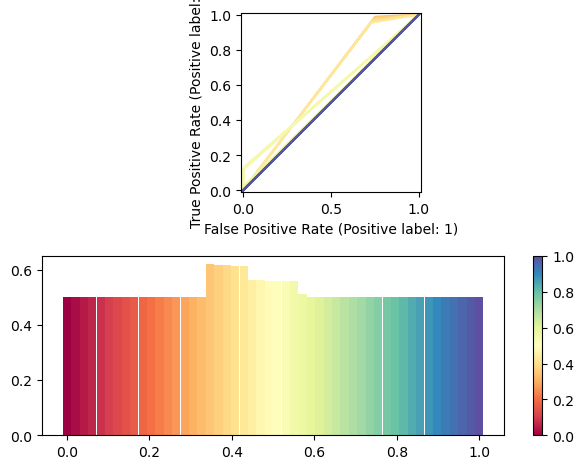

In [161]:
test_prob_thresholds(model, X, Y)

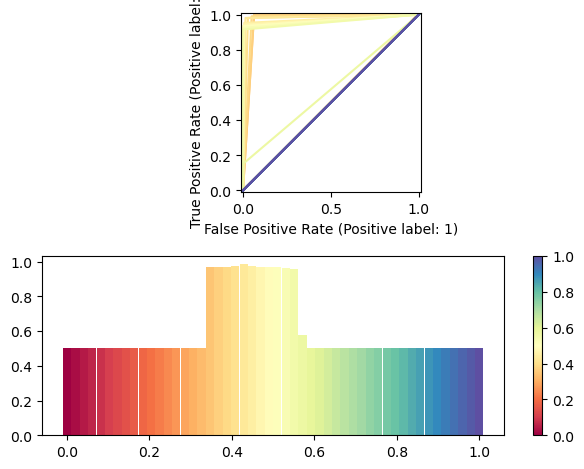

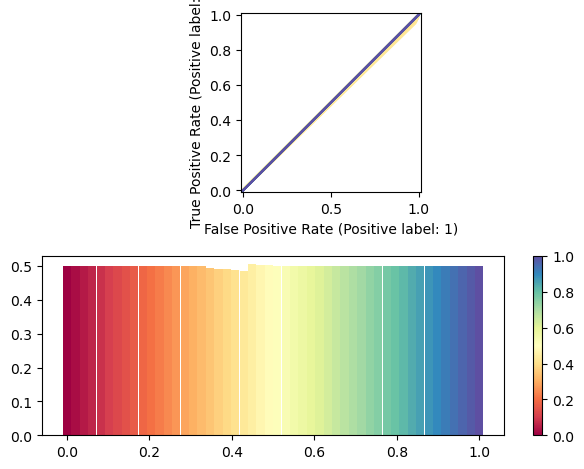

In [162]:
test_prob_thresholds(model, X.loc[train], Y.loc[train])
test_prob_thresholds(model, X.loc[test], Y.loc[test])

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


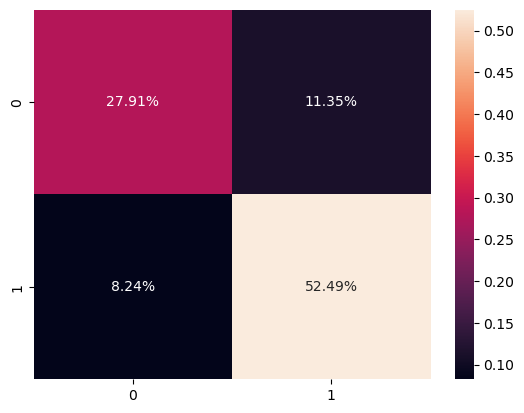

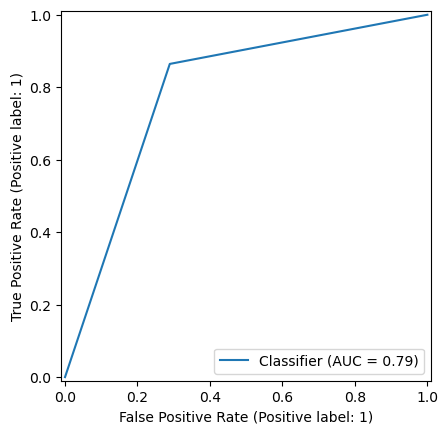

In [131]:

make_confusion_matrix(Y, model.predict_proba(X)[:, 1]>0.5)

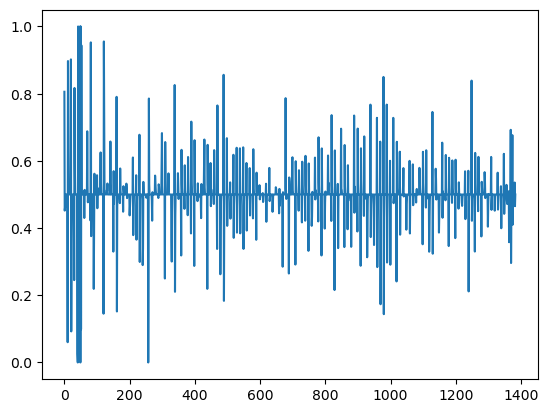

In [40]:
plt.plot(scipy.stats.norm.cdf(test_df["New Z-score"]))

[]

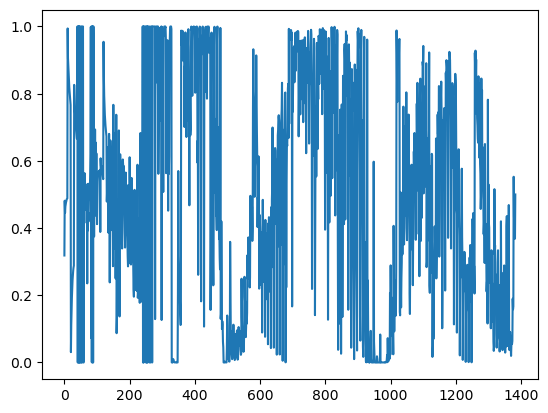

In [37]:
plt.plot(scipy.stats.norm.cdf(test_df["Observation Z-score"]))
plt.plot()